In [1]:
%pip install torchmetrics


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Metrics for RPN and GCViT

In [2]:
from torch import Tensor
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, z_score_normalization
from project.utils import collatev2, compute_statistics
import winsound
from torchvision.models import resnet18, ResNet18_Weights
from project.utils import memcheck

In [3]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 5)

In [4]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
data

,mri,masks,target,has_microbleed_case,has_microbleed_slice
0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,1,1
1,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,9,1,1
2,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,11,1,1
3,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,12,1,1
4,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,15,1,1
...,...,...,...,...,...
359,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,25,1,1
360,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,26,1,1
361,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,24,1,1
362,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,25,1,1


In [5]:
ch1 = ds.load_raw_mri(1)
data = data[data.mri.isin(ch1)]
data.shape

(45, 5)

In [6]:
cases = data.mri
masks = data.masks
target = data.target

global_min, global_max = compute_statistics(data.mri.tolist())

# global_min = 0.0
# global_max = 1417.92822265625

In [7]:
global_min, global_max

(0.0, 1417.92822265625)

In [8]:
image_size = 300

In [9]:
transform = NiftiToTensorTransform(
    target_shape = (image_size, image_size), 
    rpn_mode=True,
    normalization=(global_min, global_max)
)

In [10]:
dataset = VALDODataset(
    cases=data.mri,
    masks=data.masks,
    target=data.target,
    transform=transform,
)

dataset_loader = DataLoader(
    dataset,
    shuffle=False,
    batch_size=1,
    collate_fn=collatev2,
)


## RPN metrics

In [11]:
from project.model import RPN

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

rpn_model = RPN(
    input_dim=512,
    output_dim=4,
    image_size=image_size,
    nh=4
).to(device)

1369


c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [12]:
rpn_model.load_state_dict(torch.load('test_weights/RPN_test_normalizations_weights_281024113758.pt'))

<All keys matched successfully>

### IOU

In [13]:
from torchmetrics.functional.detection import intersection_over_union
from torchvision.ops import box_area
from typing import Tuple


In [14]:
def _upcast(t: Tensor) -> Tensor:
    # Protects from numerical overflows in multiplications by upcasting to the equivalent higher type
    if t.is_floating_point():
        return t if t.dtype in (torch.float32, torch.float64) else t.float()
    else:
        return t if t.dtype in (torch.int32, torch.int64) else t.int()

def _box_inter_union(boxes1: Tensor, boxes2: Tensor) -> Tuple[Tensor, Tensor]:
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    wh = _upcast(rb - lt).clamp(min=0)  # [N,M,2]
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

    union = area1[:, None] + area2 - inter

    return inter, union

In [15]:
iou_scores = []
preds = []
truth = []
cases = []
targets = []
precision_scores = []
recall_scores = []
f1_scores = []
counter = 0

with torch.no_grad():
    for batch in enumerate(dataset_loader):
        slices, masks, target, case = batch[1][0]
        x = slices.squeeze(1).float().to(device)
        T = masks.squeeze(1).float().to(device)/image_size

        y = rpn_model(x, target)

        preds.append((y *  image_size).squeeze().detach().cpu().numpy())
        truth.append((T[target] * image_size).squeeze().detach().cpu().numpy())
        cases.append(case)
        targets.append(target)

        iou_score = intersection_over_union(y * image_size, T[target] * image_size)
        print(f'{counter} IOU score:', iou_score)

        inter, union = _box_inter_union(y * image_size, T[target] * image_size)

        precision_score = (inter / box_area(y * image_size))
        recall_score = (inter / box_area(T[target] * image_size))

        if any([precision_score, recall_score]) == 0:
            f1_score = 0
            f1_scores.append(f1_score)
        else:
            f1_score = (2 * (precision_score * recall_score)) / (precision_score + recall_score)
            f1_scores.append(f1_score.detach().cpu().numpy())
        
        print(f'{counter} Precision score:', precision_score)
        print(f'{counter} Recall score:', recall_score)
        print(f'{counter} F1 score:', f1_score)

        print()

        iou_scores.append(iou_score.detach().cpu().numpy())
        precision_scores.append(precision_score.squeeze().squeeze().detach().cpu().numpy())
        recall_scores.append(recall_score.squeeze().squeeze().detach().cpu().numpy())
        counter += 1


c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


0 IOU score: tensor(0., device='cuda:0')
0 Precision score: tensor([[0.]], device='cuda:0')
0 Recall score: tensor([[0.]], device='cuda:0')
0 F1 score: 0

1 IOU score: tensor(0., device='cuda:0')
1 Precision score: tensor([[-0.]], device='cuda:0')
1 Recall score: tensor([[0.]], device='cuda:0')
1 F1 score: 0

2 IOU score: tensor(0., device='cuda:0')
2 Precision score: tensor([[0.]], device='cuda:0')
2 Recall score: tensor([[0.]], device='cuda:0')
2 F1 score: 0

3 IOU score: tensor(0.1789, device='cuda:0')
3 Precision score: tensor([[0.1879]], device='cuda:0')
3 Recall score: tensor([[0.7897]], device='cuda:0')
3 F1 score: tensor([[0.3036]], device='cuda:0')

4 IOU score: tensor(0., device='cuda:0')
4 Precision score: tensor([[0.]], device='cuda:0')
4 Recall score: tensor([[0.]], device='cuda:0')
4 F1 score: 0

5 IOU score: tensor(0., device='cuda:0')
5 Precision score: tensor([[-0.]], device='cuda:0')
5 Recall score: tensor([[0.]], device='cuda:0')
5 F1 score: 0

6 IOU score: tensor(0.

In [16]:
score_dict = {
    'Case': cases,
    'Target': targets,
    'Ground_Truth': truth,
    'Predictions': preds,
    'IOU': iou_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1': f1_scores
}

score_df = pd.DataFrame(score_dict)

In [17]:
score_df

,Case,Target,Ground_Truth,Predictions,IOU,Precision,Recall,F1
0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,"[90.234375, 169.33594, 113.671875, 202.73438]","[112.54228, 163.25215, 110.1083, 153.03012]",0.0,0.0,0.0,0
1,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,9,"[144.72656, 181.64062, 158.20312, 195.70312]","[116.80745, 153.32335, 97.01457, 215.12372]",0.0,-0.0,0.0,0
2,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,11,"[157.03125, 196.28906, 170.50781, 209.76562]","[95.87456, 147.01395, 117.49143, 178.77136]",0.0,0.0,0.0,0
3,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,12,"[130.66406, 177.53906, 159.96094, 195.70312]","[100.28219, 154.255, 158.81868, 192.46541]",0.17893392,0.18788618,0.7897122,[[0.30355206]]
4,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,15,"[84.96094, 104.296875, 99.609375, 118.359375]","[93.7446, 134.1962, 99.134285, 192.24222]",0.0,0.0,0.0,0
5,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,16,"[145.89844, 120.703125, 167.57812, 185.15625]","[108.84779, 149.40875, 128.7989, 130.4712]",0.0,-0.0,0.0,0
6,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,17,"[151.17188, 126.5625, 169.33594, 181.05469]","[131.43437, 118.98798, 130.58882, 136.67873]",0.0,-0.0,0.0,0
7,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,27,"[142.96875, 171.67969, 157.03125, 186.32812]","[57.95321, 119.17158, 74.474495, 143.74281]",0.0,0.0,0.0,0
8,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,17,"[138.28125, 179.29688, 155.27344, 196.28906]","[129.81274, 156.81639, 155.61298, 158.09135]",0.0,0.0,0.0,0
9,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,5,"[71.484375, 157.03125, 86.71875, 171.67969]","[128.43365, 178.8566, 143.07404, 193.34859]",0.0,0.0,0.0,0


#### Average IOU score

In [18]:
avg = sum(iou_scores) / len(iou_scores)
print(avg)

0.07290693919381333


#### Average Precision score

In [19]:
avg = sum(precision_scores) / len(precision_scores)
print(avg)

0.22017698247089154


#### Average Recall score

In [20]:
avg = sum(recall_scores) / len(recall_scores)
print(avg)

0.19467328575750192


#### Average F1 score

In [21]:
avg = sum(f1_scores) / len(f1_scores)
print(avg)

[[0.12146556]]


#### Plotting of highest score

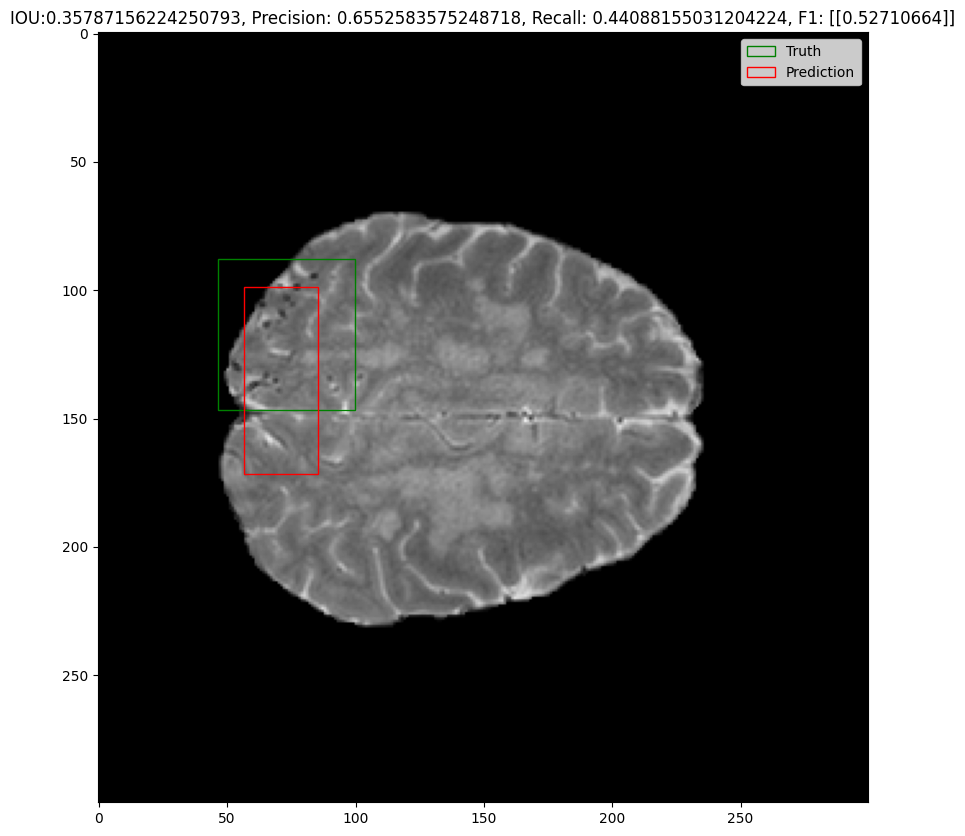

In [22]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

num = iou_scores.index(max(iou_scores))

slices, masks, target, case = dataset[num]

truth_bbox = truth[num]
predicted_bbox = preds[num]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(slices[target][0, 0, :], cmap='gray')
# Create the bounding box rectangle
truth_rect = patches.Rectangle(
    (truth_bbox[0], truth_bbox[1]),  # (x_min, y_min)
    truth_bbox[2] - truth_bbox[0],   # width
    truth_bbox[3] - truth_bbox[1],   # height
    linewidth=1, edgecolor='g', facecolor='none',  # red bounding box
    label='Truth'
)

# Create the bounding box rectangle
predicted_rect = patches.Rectangle(
    (predicted_bbox[0], predicted_bbox[1]),  # (x_min, y_min)
    predicted_bbox[2] - predicted_bbox[0],   # width
    predicted_bbox[3] - predicted_bbox[1],   # height
    linewidth=1, edgecolor='r', facecolor='none',  # red bounding box
    label='Prediction'
)

ax.set_title(f'IOU:{iou_scores[num]}, Precision: {precision_scores[num]}, Recall: {recall_scores[num]}, F1: {f1_scores[num]}')

# Add the rectangle to the axis
ax.add_patch(truth_rect)
ax.add_patch(predicted_rect)

ax.legend()